In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as ticker
from scipy.integrate import simps
from scipy.optimize import curve_fit


from sklearn.linear_model import LinearRegression

In [260]:
BASE_PATH = '../tp5/out/flux/'

In [261]:
def get_linear_regresssion(df):
    x = np.array(df.index)
    y = np.array(df['sum'])
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m , c

In [262]:
def get_simulation_data(df):
    time_flux = df.groupby('time').agg({'ball_id':'count'}); 
    return {
        'discharge' : pd.DataFrame({'time': time_flux.index,'sum': time_flux.cumsum()['ball_id']})
    }

In [263]:
def plot_flux(figure, tiempo, discharge, line, shared_ax, label):
    if shared_ax is None:
        plt.plot(tiempo, discharge,marker='x', label='Descarga')
        plt.plot(tiempo, line, label='Regresión lineal')
        plt.xlabel('Tiempo')
        plt.ylabel('Cantidad de pelotas')
        plt.legend()
        plt.savefig(figure)
        plt.clf()
    else:
        # color = next(shared_ax._get_lines.prop_cycler)['color']
        shared_ax.plot(tiempo, discharge, label=label, marker='x')
        shared_ax.plot(tiempo, line)

In [264]:
def plot_map(name,plot_map, xlabel, ylabel, log_scale):
    x = [position for position in plot_map.keys()]
    y = [value[0] for value in plot_map.values()]
    errors = [value[1] for value in plot_map.values()]
        
    plt.errorbar(x, y, yerr=errors, fmt='o', color='black', ecolor='red', capsize=3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_scale:
        plt.yscale("log")
    plt.xticks(x)
    plt.grid(True)
    plt.savefig(name)
    plt.clf()

In [265]:
def get_charge(path):
    df = pd.read_csv(path)
    df = get_simulation_data(df)
    df = df['discharge']
    m, c = get_linear_regresssion(df)
    y = m * (df.index) + c
    S = np.sqrt(sum((df['sum'] - y) ** 2) / (len(df.time) - 2))
    time_mean = np.mean(df.index)
    SS = np.sqrt(sum((df.index - time_mean) ** 2))
    return m, (S/SS)
    

In [266]:
    # function for generating the discharge curve for the freq, 
    # receiving the csv path as parameter
    def plot_discharge_line_for_freq(freq, path, shared_ax):        
        df = pd.read_csv(path)
        df = get_simulation_data(df)
        df = df['discharge']
        m, c = get_linear_regresssion(df)
        y = m * (df.index) + c
        plot_flux(f'{freq}Discharge.png',df.index, df['sum'], y, shared_ax, str(freq))

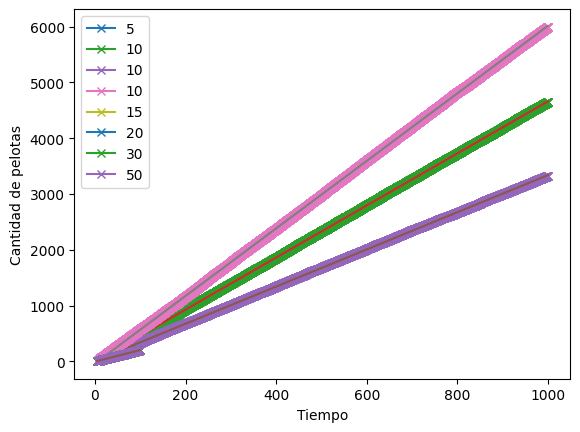

<Figure size 640x480 with 0 Axes>

In [267]:
# Ejercicio 1. 
def plot_caudal_by_frequency():
    path = f"{BASE_PATH}/"
    frequencies = [5,10, 15,20, 30,50]
    result = {}
    fig, shared_ax = plt.subplots()

    for freq in frequencies: 
        regex = '*fq'+ str(freq)+'_*_i*.csv'
        files = Path(path).glob(regex)
        for f in files: 
            dfs = get_charge(f)
            plot_discharge_line_for_freq(freq, f, shared_ax)
        result[freq] = dfs
        
    shared_ax.set_xlabel('Tiempo')
    shared_ax.set_ylabel('Cantidad de pelotas')
    shared_ax.legend()
    plt.show()
    plt.clf()
    plot_map("fluxVsFreq.png", result, "Frecuencia", "Caudal", False)

plot_caudal_by_frequency()

In [268]:
    # function for generating the discharge curve for the gap, 
    # receiving the csv path as parameter
    def plot_discharge_line_for_gap(gap, path, ax):        
        df = pd.read_csv(path)
        df = get_simulation_data(df)
        df = df['discharge']
        m, c = get_linear_regresssion(df)
        y = m * (df.index) + c
        plot_flux(f"{gap}_Discharge.png", df.index, df['sum'], y, ax, gap)

<Figure size 640x480 with 0 Axes>

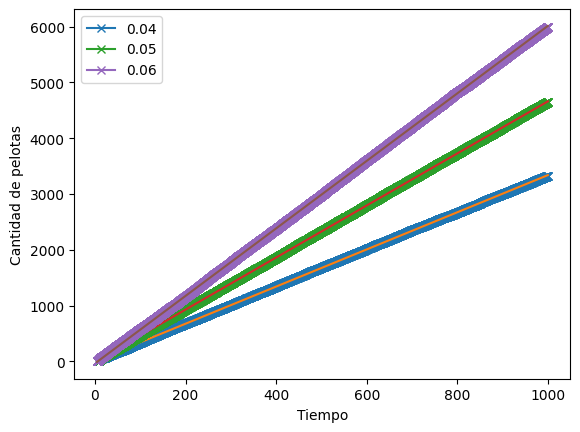

In [269]:
# Ej 2. 
def plot_discharge_line(freq):
    base = f"{BASE_PATH}/"
    gaps = [0.04, 0.05, 0.06]
    
    plt.clf()
    fig, shared_ax = plt.subplots()
    for gap in gaps: 
        regex = f"*fq{freq}_gap"+ str(gap)+'*_i*.csv'
        files = Path(base).glob(regex)
        path = [f for f in files][0]
        plot_discharge_line_for_gap(gap, path, shared_ax)
        
    shared_ax.set_xlabel('Tiempo')
    shared_ax.set_ylabel('Cantidad de pelotas')
    shared_ax.legend()
    
    plt.show()

OPTIMAL_FREQ = 10
plot_discharge_line(OPTIMAL_FREQ)

In [270]:
# generate all the discharge curves  
def plot_discharge_line():
    base = f"{BASE_PATH}/"
    frequencies = [5,10, 15, 20, 30, 50]
    for freq in frequencies: 
        regex = '*fq'+ str(freq)+'*_i*.csv'
        files = Path(base).glob(regex)
        path = [f for f in files][0]
        plot_discharge_line_for_freq(freq, path, None)

plot_discharge_line()

<Figure size 640x480 with 0 Axes>

In [271]:
def get_caudal_by_gap(freq):
    path = f"{BASE_PATH}/"
    gaps = [0.04, 0.05, 0.06]
    caudales = []
    result = {}
    result_map = {}
    for gap in gaps: 
        regex = f"*fq{freq}_gap{gap}*_i*.csv"

        files = Path(path).glob(regex)
        caudal = [get_charge(f) for f in files][0]
        result_map[gap] = caudal
        caudales.append(caudal[0])
        
    result["d"] = gaps
    result["q"] = caudales
    
        
    plot_map("fluxVsAncho.png", result_map, "Ancho(m)", "Caudal", False)

    return result

In [272]:
get_caudal_by_gap(10)

{'d': [0.04, 0.05, 0.06],
 'q': [3.3288953544329014, 4.664583318972616, 6.049129405480214]}

<Figure size 640x480 with 0 Axes>

In [273]:
# Definir la función lineal
def linear_func(d, c):
    return d - (0.01)*c

def plot_beverloo(points,c):
    B = (200 /(0.35 * 0.2)) * np.sqrt(0.05)
    r = 0.01
    x = np.arange(np.abs(c*r), 0.07, 0.001)
    y = B * ((x-c*r)**1.5)
    x_p = [p[0] for p in points]
    y_p = [p[1] for p in points]
    
    plt.plot(x,y, label='Ley de Beverloo')
    plt.plot(x_p, y_p, marker='x', linestyle='None',label='Resultados')
    plt.xlabel('Ancho(m)')
    plt.ylabel('Caudal ')
    # plot(points)
    plt.legend()
    plt.savefig("Beverloo.png")

1.251774370887102
[0.99446269 1.23645369 1.52440674]


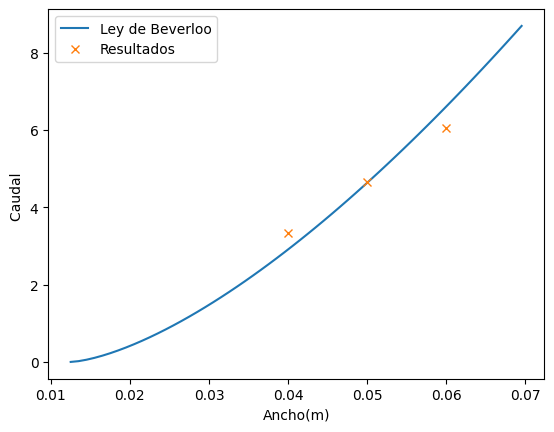

In [274]:
dictio = get_caudal_by_gap(10)
D = dictio["d"]
Q = dictio["q"]
D = np.array(D) #pasando a centimetros
B = (200 /(0.35 * 0.2)) * np.sqrt(0.05)
Q_despejado = np.exp((np.log(Q/B))/(1.5))

popt, _ = curve_fit(linear_func, D, Q_despejado)
b_opt = popt[0] # c que aproxima. 
print(b_opt)
c_despejado = (D - Q_despejado)/(0.01) 
print(c_despejado)

points = []
for d,q in zip(D,Q):
    points.append((d,q))

plot_beverloo(points, b_opt)

In [275]:
# time_delta = 1
# time_bins = np.arange(0, 10, time_delta)

# data = []
# df_without_index = df.reset_index()
# for i in range(0, len(time_bins) - 1):
#     lower = time_bins[i]
#     upper = time_bins[i + 1]

#     particles = df_without_index[(df_without_index['time'] < upper) & (df_without_index['time'] >= lower)]['ball_id'].sum()
#     data.append({'time': lower, 'particles': particles})

# q_df = pd.DataFrame(data)
# q_df.plot(x='time', y='particles')

# q_df.mean()

In [276]:
# rolling_df = df.copy().reset_index()
# rolling_df['Timestamp'] = pd.to_datetime(rolling_df['time'], unit='s')
# rolling_df.set_index('Timestamp', inplace=True)
# rolling_df.rolling(window='1000ms')['ball_id'].sum().plot()

## Comparación sin oscilación

1. Identificar valor de C para Beverloo con sistema no oscilatorio
2. Calcular el impacto en el "d" efectivo al oscilar el sistema

In [247]:
VOLUME_HEIGHT = 0.70 # meters
VOLUME_WIDTH = 0.2 # meters
PARTICLES_AMOUNT = 200
PARTICLE_AVG_RADIUS = 0.01 # meters
GRAVITY = 0.05 # m/s²

In [248]:
def approximate_beverloo_c(
    D: list[float],
    Q: list[float],
    volume_width=VOLUME_WIDTH,
    volume_height=VOLUME_HEIGHT,
    particles_amount=PARTICLES_AMOUNT,
    particle_avg_radius=PARTICLE_AVG_RADIUS,
    gravity=GRAVITY
):
    D = np.array(D)
    total_volume = volume_width * volume_height
    B = (particles_amount /(volume_height * volume_width)) * np.sqrt(gravity)
    Q_despejado = np.exp(np.log(Q / B) / 1.5)

    popt, _ = curve_fit(linear_func, D, Q_despejado)
    b_opt = popt[0] # c que aproxima.

    return b_opt

In [249]:
def beverloo_df(
    x,
    c,
    volume_width=VOLUME_WIDTH,
    volume_height=VOLUME_HEIGHT,
    particles_amount=PARTICLES_AMOUNT,
    particle_avg_radius=PARTICLE_AVG_RADIUS,
    gravity=GRAVITY
):
    total_volume = volume_width * volume_height
    B = particles_amount / total_volume * np.sqrt(gravity)
    
    y = B * ((x - c * particle_avg_radius) ** 1.5)
    
    return pd.DataFrame({'x': x, 'y': y})

In [250]:
def plot_beverloo_curve(df, ax, label="Ley de Beverloo"):
    # df = df[(df['x'] > 0.037) & (df['x'] < 0.063)].copy()
    
    ax.plot(df['x'], df['y'], label=label)
    
def plot_beverloo_experiment_data_points(df, ax, label="Resultados", marker='o'):
    x_p = [p[0] for p in df]
    y_p = [p[1] for p in df]
    
    ax.plot(x_p, y_p, marker=marker, linestyle='None', label=label, alpha=1)

In [251]:
def get_caudal_df(freq: int):
    path = f"{BASE_PATH}/"
    gaps = [0.04, 0.05, 0.06]
    caudales = []
    result_map = {}
    
    for gap in gaps: 
        regex = f"*fq{freq}_gap{gap}*_i*.csv"
        files = Path(path).glob(regex)
        caudal = [get_charge(f) for f in files][0]
        result_map[gap] = caudal
        caudales.append(caudal[0])

    return {"d": gaps, "q": caudales}

{'d': [0.04, 0.05, 0.06], 'q': [3.3288953544329014, 4.664583318972616, 6.049129405480214]}
Fitted c: 1.251774370887102


Text(0, 0.5, 'Caudal (partículas / s)')

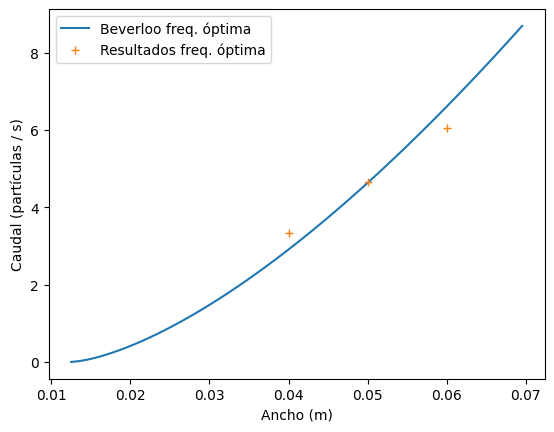

In [252]:
optimal_freq_data = get_caudal_df(freq=10)
print(optimal_freq_data)
c = approximate_beverloo_c(optimal_freq_data['d'], optimal_freq_data['q'])
print(f"Fitted c: {c}")

x = np.arange(c * PARTICLE_AVG_RADIUS, 0.07, 0.001)

beverloo = beverloo_df(x, c)

fig, ax = plt.subplots()

plot_beverloo_curve(beverloo, ax, "Beverloo freq. óptima")
plot_beverloo_experiment_data_points([x for x in zip(D, Q)], ax, "Resultados freq. óptima", '+')

ax.legend()
ax.set_xlabel('Ancho (m)')
ax.set_ylabel('Caudal (partículas / s)')

# plt.show()

{'d': [0.04, 0.05, 0.06], 'q': [3.1775767935953043, 4.365045121165831, 5.772821931800284]}
Fitted c: 1.3824497011895833


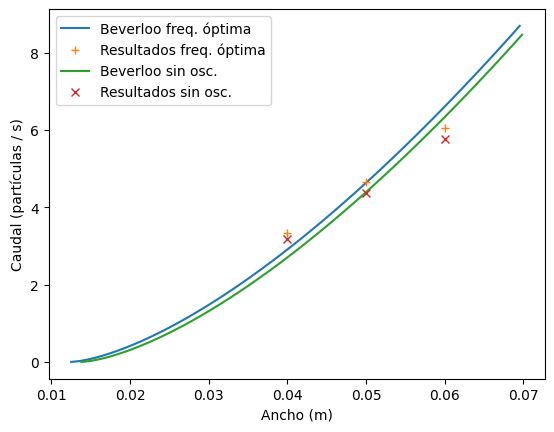

In [253]:
no_oscilation_data = get_caudal_df(freq=0)
print(no_oscilation_data)
no_oscilation_d = no_oscilation_data['d']
no_oscilation_q = no_oscilation_data['q']
no_oscilation_c = approximate_beverloo_c(no_oscilation_d, no_oscilation_q)

print(f"Fitted c: {no_oscilation_c}")

x = np.arange(no_oscilation_c * PARTICLE_AVG_RADIUS, 0.07, 0.001)

beverloo = beverloo_df(x, no_oscilation_c)

plot_beverloo_curve(beverloo, ax, "Beverloo sin osc.")
plot_beverloo_experiment_data_points([x for x in zip(no_oscilation_d, no_oscilation_q)], ax, "Resultados sin osc.", 'x')

ax.legend()

fig

In [254]:
plt.clf()

<Figure size 640x480 with 0 Axes>

      x     osc_y  no_osc_y   y_ratio
0  0.04  3.328895  3.177577  4.762074
1  0.05  4.664583  4.365045  6.862202
2  0.06  6.049129  5.772822  4.786350


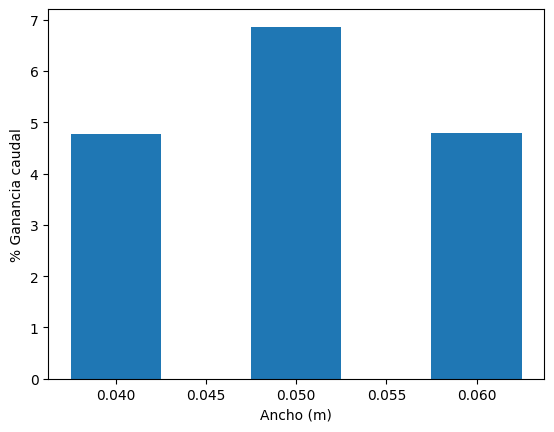

In [257]:
comparison_c_df = pd.DataFrame({'x': optimal_freq_data['d'], 'osc_y': optimal_freq_data['q'], 'no_osc_y': no_oscilation_q})
comparison_c_df['y_ratio'] = (comparison_c_df['osc_y'] - comparison_c_df['no_osc_y']) / comparison_c_df['no_osc_y'] * 100

plt.bar(x=comparison_c_df['x'], width=0.005, height=comparison_c_df['y_ratio'])
plt.xlabel('Ancho (m)')
plt.ylabel('% Ganancia caudal')

print(comparison_c_df)

Text(0, 0.5, 'c')

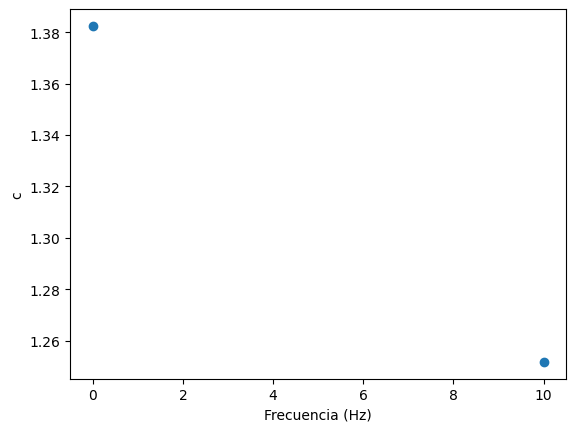

In [258]:
data = [[0, no_oscilation_c], [10, no_oscilation_c]]
c_df = pd.DataFrame({'x': [0, 10], 'y': [no_oscilation_c, c]})
plt.scatter(x=c_df['x'], y=c_df['y'])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('c')